In [121]:
import numpy as np
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.base import ClassifierMixin

xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(300, 2)
y = np.array(np.logical_xor(X[:, 0] > 0, X[:, 1] > 0), 
             dtype=int)

In [122]:
class SimpleVFDT(ClassifierMixin):
    def __init__(self, delta=0.05, min_seen=100):
        self.proposal_scores = None
        self.n_seen = 0 
        self.delta = delta
        self.min_seen = min_seen
        self.base_node = GaussianNB()
        self.left_node = GaussianNB()
        self.right_node = GaussianNB()
    
    def fit(self, X, y):
        self.proposal_scores = None
        self.n_seen = 0
        self.feat = None
        self.val = None
        self.impurity = None
        self.is_split = False
        return self.partial_fit(X, y)
    

    def hoeffding_bound(self, n):
        return np.sqrt(0.25 * np.log(1 / self.delta) / (2 * n))
        
        
    def partial_fit(self, X, y):
        if self.n_seen == 0:
            self.base_node.fit(X, y)
        else:
            self.base_node.partial_fit(X, y)
            
        self.n_seen += X.shape[0]
        
        proposed_splits = np.mean(self.base_node.theta_, 0)
        if self.proposal_scores is None:
            self.proposal_scores = np.zeros(X.shape[1])
        for feat_idx in range(X.shape[1]):
            y_indx = X[:, feat_idx] < proposed_splits[feat_idx]
            self.proposal_scores[feat_idx] += np.sum(y[y_indx])
            
        impurity = [
            2 * (x / self.n_seen) * (1 - x / self.n_seen) for x in self.proposal_scores
        ]  # this isn't 100% correct, I'm just lazy...
        
        vals = sorted(impurity.copy())[:2]
        is_split = False
        split_info = None
        if not self.is_split and np.abs(vals[0] - vals[1]) < self.hoeffding_bound(self.n_seen) and self.n_seen >= self.min_seen:
            # create a sub node, just hardcode, and leave as an exercise 
            # for someone to have a dynamic programming solution
            self.is_split = True
            self.feat = np.argmin(impurity)
            self.val = proposed_splits[self.feat]
            y_indx = X[:, self.feat] < proposed_splits[self.feat]
            self.left_node.fit(X, y)
            self.right_node.fit(X, y)
        elif self.is_split:
            self.val = proposed_splits[self.feat]
            y_indx = X[:, self.feat] < proposed_splits[self.feat]
            self.left_node.partial_fit(X[y_indx, :], y[y_indx])
            self.right_node.partial_fit(X[~y_indx, :], y[~y_indx])
        return self
        
    def predict(self, X):
        lpred = self.left_node.predict(X)
        rpred = self.right_node.predict(X)
        y_indx = X[:, self.feat] < self.val
        mask = np.hstack([y_indx.reshape(-1, 1), (~y_indx).reshape(-1, 1)])
        all_pred = np.stack([lpred, rpred], 1)
        print(all_pred.shape)
        print(mask.shape)
        return np.max(all_pred * mask, 1)

In [123]:
mod = GaussianNB()
mod.fit(X, y)

GaussianNB()

In [124]:
%matplotlib inline

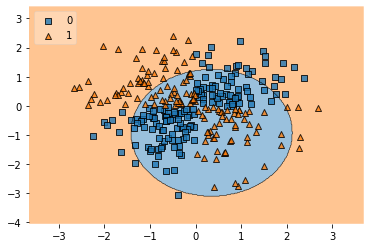

In [125]:
fig = plot_decision_regions(X=X, y=y, clf=mod, legend=2)

In [126]:
vfdt = SimpleVFDT()

def generate_sample(n=10):
    X = rng.randn(n, 2)
    y = np.array(np.logical_xor(X[:, 0] > 0, X[:, 1] > 0), 
             dtype=int)
    return X, y

X1, y1 = generate_sample()
vfdt.fit(X1, y1)

while not vfdt.is_split:
    X1, y1 = generate_sample()
    vfdt.partial_fit(X1, y1)
    
# train a few more times for good measure
for _ in range(10):
    X1, y1 = generate_sample()
    vfdt.partial_fit(X1, y1)

(124416, 2)
(124416, 2)


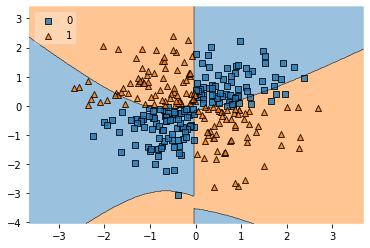

In [127]:
fig = plot_decision_regions(X=X, y=y, clf=vfdt, legend=2)